# Chest X-Ray Report Generation:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/My Drive/Colab Notebooks/NLMCXR_png.zip' -d '/content'

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
import pickle
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import sentence_bleu
import warnings
warnings.filterwarnings('ignore')

# Reading data:

In [2]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/preprocessed_data.csv')

In [3]:
df

,Frontal,Lateral,indication,findings,impression,count
0,CXR594_IM-2187-1001.png,CXR594_IM-2187-2001.png,pain weakness,there are t spine osteophytes there calcified ...,borderline cardiomegaly age indeterminate chro...,2
1,CXR532_IM-2140-1001.png,CXR532_IM-2140-2001.png,woman vehicle collision,the lungs are clear bilaterally specifically n...,no acute cardiopulmonary abnormality,2
2,CXR541_IM-2147-1001.png,CXR541_IM-2147-1001.png,chest pain,cardiomediastinal contour and pulmonary vascul...,no acute cardiopulmonary findings age indeterm...,1
3,CXR569_IM-2169-0001-0002.png,CXR569_IM-2169-0001-0001.png,rule out aspiration,the heart size and pulmonary vascularity appea...,continued elevation of the left hemidiaphragm ...,2
4,CXR581_IM-2178-1001.png,CXR581_IM-2178-3001.png,dyspnea asthma,frontal and lateral views of the chest show an...,no acute or active cardiac pulmonary or pleura...,2
...,...,...,...,...,...,...
4059,CXR885_IM-2399-2001.png,CXR885_IM-2399-2001.png,with ongoing shortness of breath and history o...,heart size mediastinal contour and pulmonary v...,no acute cardiopulmonary abnormality postsurgi...,1
4060,CXR88_IM-2394-2001.png,CXR88_IM-2394-2001.png,worsening dyspnea history of coronary artery d...,heart is mildly heart enlarged mediastinal con...,findings consistent with mild congestive heart...,1
4061,CXR900_IM-2408-2001.png,CXR900_IM-2408-2001.png,allogeneic bmt w u lab,the heart is normal in size the mediastinum is...,no acute disease,1
4062,CXR904_IM-2409-3003.png,CXR904_IM-2409-3003.png,painful chest,normal heart size left chest tip mid svc right...,stable appearance of the chest no or acute fin...,1


In [4]:
add_list = []
for i in df['impression'] :
  add_list.append('<start> ' + i + ' <end>')# adding start and end to sentence
df['impression'] = add_list

# Splitting data:

In [5]:
y = df['impression']
X = df.drop(['impression'],axis = 1)
X_train,X_cv,y_train,y_cv = train_test_split(X,y,test_size = 0.3,stratify = df['count'],random_state = 10)

In [6]:
X_train

,Frontal,Lateral,indication,findings,count
2499,CXR2231_IM-0831-2001.png,CXR2231_IM-0831-1001.png,dyspnea,heart mediastinum bony structures are unremark...,3
1130,CXR3559_IM-1744-1001.png,CXR3559_IM-1744-2001.png,no indication,heart size within normal limits negative for f...,2
3336,CXR1432_IM-0278-1001.png,CXR1432_IM-0278-2001.png,copd,heart size and pulmonary vascularity appear wi...,2
1942,CXR2653_IM-1137-1001.png,CXR2653_IM-1137-2001.png,with chest pain,heart size and mediastinal contours appear wit...,2
2963,CXR1974_IM-0633-1001.png,CXR1974_IM-0633-2001.png,chest pain,the lungs are clear the cardiomediastinal silh...,2
...,...,...,...,...,...
2105,CXR2730_IM-1189-1001.png,CXR2730_IM-1189-2001.png,chest pain shortness of breath dizziness,heart size and pulmonary vascular engorgement ...,2
2442,CXR2261_IM-0852-1001.png,CXR2261_IM-0852-2001.png,chest pain today,frontal and lateral views of the chest with ov...,2
3036,CXR1937_IM-0607-1001.png,CXR1937_IM-0607-2001.png,tobacco use pre op evaluation,heart size and pulmonary vascularity appear wi...,2
2596,CXR2408_IM-0955-4004.png,CXR2408_IM-0955-2001.png,no indication,cardiomediastinal contour stable and within no...,2


In [7]:
X_train = X_train.drop(['indication','findings','count'],axis = 1)
X_cv = X_cv.drop(['indication','findings','count'],axis = 1)

In [8]:
print(X_train.shape,X_cv.shape)

(2844, 2) (1220, 2)


In [9]:
def max_length1(K) :
  'finding maximum length in documents'
  l = []
  for i in K :
    num = 0
    for j in i.split(" ") :
      num += 1
    l.append(num)
  return max(l)
length = max_length1(y_train)
max_doc_length_x = length
print(length)

125


# Tokenization:

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer(filters="")#oov_token="<unknown>",
tokenizer.fit_on_texts(y_train)

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

vocab_size = len(tokenizer.word_index) + 1
print('Max document length: %d' % length)
print('Vocabulary size: %d' % vocab_size)
imp_vocab_size = vocab_size

encoded = tokenizer.texts_to_sequences(y_train)
enc_train_in = pad_sequences(encoded, maxlen=length, padding='post', truncating='post')

encoded2 = tokenizer.texts_to_sequences(y_cv)
enc_val_in = pad_sequences(encoded2, maxlen=length, padding='post', truncating='post')

enc_train_in = np.array(enc_train_in)
enc_val_in   = np.array(enc_val_in)


Max document length: 125
Vocabulary size: 1291


In [79]:
import pickle
# saving
with open('/content/drive/My Drive/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [11]:
enc_train_in[4]

array([ 1, 56, 18,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0], dtype=int32)

In [12]:
print(list(tokenizer.word_index.items())[:5])

[('<start>', 1), ('<end>', 2), ('no', 3), ('acute', 4), ('cardiopulmonary', 5)]


In [13]:
enc_train_in.shape,enc_val_in.shape

((2844, 125), (1220, 125))

In [14]:
f = open('/content/drive/My Drive/Colab Notebooks/glove_vectors','rb') # 300d glove vectors  
glove_vectors = pickle.load(f)
f.close()

In [15]:
vocab_size = len(tokenizer.word_index.keys()) 

embedding_matrix = np.zeros((vocab_size,300))
for word, i in tokenizer.word_index.items():
    if word in glove_vectors.keys():
        vec = glove_vectors[word]
        embedding_matrix[i] = vec
    else:
        continue

In [16]:
import tensorflow as tf


In [17]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [18]:
import tensorflow as tf
#from tensorflow.keras.applications import EfficientNetB7,preprocess_input
from tensorflow.keras.applications.efficientnet import EfficientNetB7,preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tqdm import tqdm
from tensorflow.keras.layers import Input,Dense,LSTM,Embedding,Concatenate
#tf.enable_eager_execution()


# Extract Features from Image using EfficientNet

In [19]:
model_image = EfficientNetB7(include_top=False, weights='imagenet',classifier_activation='softmax', pooling='avg')
effiencient_in_layer = model_image.input
efficient_out_layer = model_image.layers[-1].output
features_image_model = Model(effiencient_in_layer, efficient_out_layer) 

In [20]:
image_id = []
for i,j in zip(df['Frontal'].values, df['Lateral'].values):
  image_id.append(i)
  image_id.append(j)
image_id = set(image_id)
image_id = list(image_id)# getting list of all unique images

In [ ]:
tensor_image1 = []
for id in tqdm(image_id) :
    image_vec = tf.io.read_file('/content/NLMCXR_png/' + str(id))#reading image
    image_vec = tf.image.decode_jpeg(image_vec, channels=3)
    image_vec = tf.image.resize(image_vec, (299, 299))
    image_vec = preprocess_input(image_vec)
    
    features_of_image = features_image_model(tf.constant(image_vec)[None, :])

    features_of_image = tf.reshape(features_of_image,
                              (-1, features_of_image.shape[1]))
    
    tensor_image1.append(features_of_image)# getting tensor of an image
    break;

  0%|          | 0/7438 [00:01<?, ?it/s]


In [ ]:
# save the file for future use
#f = open('/content/drive/My Drive/Colab Notebooks/Image_features.pickle','wb')
#pickle.dump(tensor_image, f)
#f.close()

In [21]:
f = open('/content/drive/My Drive/Colab Notebooks/Image_features.pickle','rb') # contains the features from chexNet
tensor_image = pickle.load(f)
f.close()

In [22]:
for i,value in enumerate(tensor_image):
  tensor_image[i] = tf.reshape(value,[32,80])

In [23]:
tensor_image[0].shape

TensorShape([32, 80])

In [24]:
def tensor_conversion(image_vec, txt):
    return tf.convert_to_tensor([tensor_image[image_id.index(image_vec[0].decode('utf-8'))], tensor_image[image_id.index(image_vec[1].decode('utf-8'))]]), txt

### Create dataset for train and validation

In [41]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, enc_train_in))

# Use map to load the numpy files in parallel
train_dataset = train_dataset.map(lambda t1, t2: tf.numpy_function(
          tensor_conversion, [t1, t2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((X_cv, enc_val_in))

# Use map to load the numpy files in parallel
val_dataset = val_dataset.map(lambda t1, t2: tf.numpy_function(
          tensor_conversion, [t1, t2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)


In [42]:
for i,j in train_dataset :
  #print("Image1 & 2 tensor :\n",i)
  print("\ntext vector : ",j)
  break;


text vector :  tf.Tensor(
[  1 141 593 116  67  30  11 352  84 129 102   7  24   2   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0], shape=(125,), dtype=int32)


In [43]:
BATCH_SIZE = 16 #specify batch size
BUFFER_SIZE = 1000
embedding_dim = 300
units = 256

In [44]:
# Shuffle and batch
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
# Shuffle and batch
val_dataset = val_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [45]:
for i,j in train_dataset :
  print("Image1 & 2 tensor :\n",i)
  u = i
  #print("\ntext vector : ",j)
  break;

Image1 & 2 tensor :
 tf.Tensor(
[[[[-1.79988658e-03  3.22644621e-01  2.52722621e-01 ... -1.50872096e-01
     5.68966158e-02  2.17019632e-01]
   [ 7.16713965e-02  1.89629510e-01  1.48371518e-01 ...  2.33739987e-01
    -4.08853441e-02 -8.51004049e-02]
   [ 8.68648738e-02 -1.97503954e-01  1.23804048e-01 ... -3.05260140e-02
     4.14005257e-02  5.00962101e-02]
   ...
   [ 5.86741567e-01  1.07004356e+00  1.10501938e-01 ... -2.84557752e-02
    -5.79290688e-02 -4.25043702e-02]
   [ 1.66982472e-01  1.71308964e-01  1.04455262e-01 ...  4.17230353e-02
    -1.68195263e-01  2.83979505e-01]
   [ 2.17767060e-01  8.64834934e-02  6.74921349e-02 ... -1.14126466e-01
     4.43045825e-01  9.64797214e-02]]

  [[-1.79988658e-03  3.22644621e-01  2.52722621e-01 ... -1.50872096e-01
     5.68966158e-02  2.17019632e-01]
   [ 7.16713965e-02  1.89629510e-01  1.48371518e-01 ...  2.33739987e-01
    -4.08853441e-02 -8.51004049e-02]
   [ 8.68648738e-02 -1.97503954e-01  1.23804048e-01 ... -3.05260140e-02
     4.14005257

In [46]:
u[0:,].shape

TensorShape([16, 2, 32, 80])

# Attention based Encoder_Decoder Model :

In [47]:
class Encoder(tf.keras.Model):
    def __init__(self, embedding_dim):
        super(Encoder, self).__init__()
        self.fc = Dense(embedding_dim, kernel_initializer=tf.keras.initializers.glorot_uniform(seed=45),
                  name="encoder_output_layer")

    def __call__(self, x):
        #x = tf.reshape(x, [x.shape[0], x.shape[1], x.shape[3]])

        encoder_concat = Concatenate()([x[:,0], x[:,1]])
        #print("encoder_concat",encoder_concat)
        x = self.fc(encoder_concat)
        x = tf.nn.relu(x)
        return x

In [48]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def __call__(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 32, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # score shape == (batch_size, 32, hidden_size)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

    # attention_weights shape == (batch_size, 32, 1)
    # you get 1 at the last axis because you are applying score to self.V
    attention_weights = tf.nn.softmax(self.V(score), axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [49]:
class Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units = units
        self.embedding = Embedding(vocab_size, output_dim=300, mask_zero=True,weights = [embedding_matrix])
        self.lstm = LSTM(self.units,activation='tanh',recurrent_activation='sigmoid', use_bias=True,
                         return_sequences=True,return_state=True,
                                       recurrent_initializer=tf.keras.initializers.glorot_uniform(seed=45))
        self.dense1 = Dense(units, kernel_initializer=tf.keras.initializers.glorot_uniform(seed=45))
        self.dense2 = Dense(vocab_size, kernel_initializer=tf.keras.initializers.glorot_uniform(seed=45))
        self.attention = BahdanauAttention(self.units)
    @tf.function(input_signature = [tf.TensorSpec(shape=[None, 1], dtype=tf.int32), tf.TensorSpec(shape=[None, 32, 300], dtype=tf.float32),tf.TensorSpec(shape=[None, 256], dtype=tf.float32)])
    def __call__(self, inputs, features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)

        x1 = self.embedding(inputs)
      
        x1 = tf.concat([x1, tf.expand_dims(context_vector,1)], axis=-1)
        #mask = self.embedding.compute_mask(x1)
        output, state, _ = self.lstm(x1)#,mask=mask
        x1 = self.dense1(output)
        x1 = tf.reshape(x1, (-1, x1.shape[2]))
        x1 = self.dense2(output)
        return x1,state,attention_weights
    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [50]:
optimizer = tf.keras.optimizers.Adam(0.001)
object_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

object_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

def loss_function(actual, pred):
    mask = tf.math.logical_not(tf.math.equal(actual, 0))
    loss_value = object_loss(actual, pred)
    mask = tf.cast(mask, dtype=loss_value.dtype)
    loss_value = loss_value*mask
    #print("mask",tf.reduce_sum(mask))
    return tf.reduce_mean(loss_value) #tf.reduce_sum(loss_value)/tf.reduce_sum(mask) #


In [51]:
!rm -r /content/logs/

In [52]:
import datetime
train_log_dir = '/content/logs/gradient_tape/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + '/train'
val_log_dir = '/content/logs/gradient_tape/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + '/val'
train_writer_summary = tf.summary.create_file_writer(train_log_dir)
val_writer_summary = tf.summary.create_file_writer(val_log_dir)

In [53]:
encoder = Encoder(embedding_dim)
decoder = Decoder(embedding_dim, units, vocab_size)

In [54]:
checkpoint_path = "/content/drive/My Drive/Colab Notebooks/checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [55]:
#tf.config.experimental_run_functions_eagerly(False)
@tf.function
#https://stackoverflow.com/questions/55063120/can-anyone-give-a-tiny-example-to-explain-the-params-of-tf-random-categorical
#https://www.tensorflow.org/tutorials/text/image_captioning
def train_step(tensor, target):
    #Initialize
    train_loss = 0
    hidden = decoder.reset_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:

        img_features = encoder(tensor)
        
        for i in range(1, target.shape[1]):
            
            predictions,hidden,_ = decoder(dec_input, img_features,hidden)
           # print("hidden",hidden)
            #[32,1,1345]

            train_loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i],1)
            
    #total_train_loss = (train_loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(train_loss, trainable_variables)


    #optimizer.apply_gradients(zip(gradients, trainable_variables))
    optimizer.apply_gradients([(grad, var) for (grad, var) in zip(gradients, trainable_variables) if grad is not None])
 
    return train_loss

#validation function
@tf.function
def val_step(tensor, target):
    val_loss_ = 0  
    hidden = decoder.reset_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        features = encoder(tensor)
        #(batch_size,embedding_dim)
        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions_val,hidden,_ = decoder(dec_input, features,hidden)
            val_loss_ += loss_function(target[:, i], predictions_val)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i],1)


    return val_loss_

# Training Model:

In [56]:

tf.keras.backend.clear_session()
EPOCHS = 10
for epoch in range(0, EPOCHS):
    start = time.time()
    total_train_loss = 0
    total_val_loss = 0
    #print('Batchwise Train loss')
    for (batch, (tensor_png, target)) in enumerate(train_dataset):
        
        tr_loss = train_step(tensor_png, target)
        total_train_loss += tr_loss
        #if batch % 40 == 0:
           # print ('Epoch {} Batch {}  Loss {:.4f}  bleu1 {:.5f} bleu2 {:.5f} bleu3 {:.5f} bleu4 {:.5f}'.format(
              #epoch + 1, batch, tr_loss,  b1,b2,b3,b4))

    with train_writer_summary.as_default():
        tf.summary.scalar('loss', total_train_loss/ int(len(X_train) // BATCH_SIZE), step=epoch)

    #print('Batchwise validation loss') 
    for (batch, (tensor_png, target)) in enumerate(val_dataset):
        tr_loss_val = val_step(tensor_png, target)
        total_val_loss += tr_loss_val

        #if batch % 50 == 0:
            #print ('Epoch {} Batch {}  Loss {:.4f} bleu1 {:.5f} bleu2 {:.5f} bleu3 {:.5f} bleu4 {:.5f}'.format(
             # epoch + 1, batch,tr_loss_val,  b1,b2,b3,b4))

    with val_writer_summary.as_default():
        tf.summary.scalar('loss', total_val_loss/int(len(X_cv) // BATCH_SIZE), step=epoch)

    template = '\nEpoch {}, Train Loss: {:.4f} Val_Loss: {:.4f} '
    print(template.format(epoch+1,
                            total_train_loss/ int(len(X_train) // BATCH_SIZE),total_val_loss/ int(len(X_cv) // BATCH_SIZE)) )
    #if epoch % 5 == 0:
      #ckpt_manager.save()
    print('Time Taken for this Epoch : {} sec'.format(time.time()-start))


Epoch 1, Train Loss: 29.0988 Val_Loss: 20.6069 
nTime Taken for this Epoch : 145.49494409561157 sec

Epoch 2, Train Loss: 18.7689 Val_Loss: 18.7045 
nTime Taken for this Epoch : 63.21380424499512 sec

Epoch 3, Train Loss: 17.0379 Val_Loss: 17.1882 
nTime Taken for this Epoch : 63.174418926239014 sec

Epoch 4, Train Loss: 15.7752 Val_Loss: 16.6865 
nTime Taken for this Epoch : 63.372236013412476 sec

Epoch 5, Train Loss: 15.0346 Val_Loss: 16.3860 
nTime Taken for this Epoch : 63.33460307121277 sec

Epoch 6, Train Loss: 14.4048 Val_Loss: 16.1889 
nTime Taken for this Epoch : 64.08434009552002 sec

Epoch 7, Train Loss: 13.9258 Val_Loss: 16.4074 
nTime Taken for this Epoch : 63.22791004180908 sec

Epoch 8, Train Loss: 13.3671 Val_Loss: 16.1170 
nTime Taken for this Epoch : 63.227606534957886 sec

Epoch 9, Train Loss: 13.0352 Val_Loss: 16.0184 
nTime Taken for this Epoch : 63.10653114318848 sec

Epoch 10, Train Loss: 12.8642 Val_Loss: 16.2680 
nTime Taken for this Epoch : 63.08101511001587

In [ ]:
#https://stackoverflow.com/questions/62250441/saving-a-tensorflow-keras-model-encoder-decoder-to-savedmodel-format
#https://stackoverflow.com/questions/51806852/cant-save-custom-subclassed-model

# Saving Model :

In [59]:
tf.saved_model.save(decoder, '/content/drive/My Drive/Colab Notebooks/decoder2/')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/decoder2/assets


In [ ]:
tf.saved_model.save(encoder,"/content/drive/My Drive/Colab Notebooks/encoder_decoder/")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/encoder_decoder/assets


In [ ]:
#tfext 
#tf.saved_model.save(decoder,"/content/drive/My Drive/Colab Notebooks/decoder_model/")
#decoder.save('/content/sample_data/')

In [60]:
%load_ext tensorboard

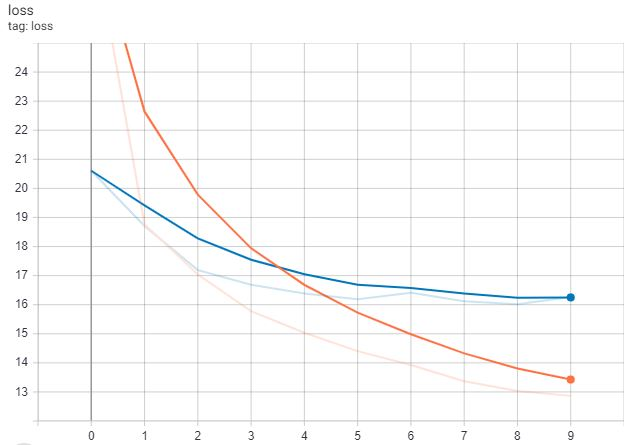

In [62]:
from IPython.display import Image
Image("/content/drive/My Drive/Colab Notebooks/enc2.JPG")

# Predictions :

In [63]:
def convert_to_tensor_ofimage(image_path,  model_image):
    image_vec = tf.io.read_file(image_path)
    image_vec = tf.image.decode_jpeg(image_vec, channels=3)
    image_vec = tf.image.resize(image_vec, (299, 299))
    image_vec = preprocess_input(image_vec)
    features_image = features_image_model(tf.constant(image_vec)[None, :])
    return features_image

In [64]:
attention_features_shape = 32

In [65]:
def evaluate(im_id):
    k1 = convert_to_tensor_ofimage("/content/NLMCXR_png/" + im_id[0], features_image_model)
    k2 = convert_to_tensor_ofimage("/content/NLMCXR_png/"+ im_id[1], features_image_model)
    k1 = tf.reshape(k1,[32,80])
    k2 = tf.reshape(k2,[32,80])
    img_tensor = tf.convert_to_tensor([k1,k2])
       
    img_features = tf.constant(img_tensor)[None, :]
    attention_plot = np.zeros((max_doc_length_x, attention_features_shape))
    features_val = encoder(img_features)
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 1)
    hidden = decoder.reset_state(batch_size=1)
    result = []
    text = ""
    for i in range(max_doc_length_x):

        predictions,hidden,attention_weights  = decoder(tf.cast(dec_input, tf.int32), features_val,hidden)
        predictions = tf.reshape(predictions, [predictions.shape[0],predictions.shape[2]])
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
        predicted_id = tf.argmax(predictions, axis=1)[0].numpy()
        if predicted_id != 0 :
          result.append(tokenizer.index_word[predicted_id])
          text += " " + tokenizer.index_word[predicted_id]
        if tokenizer.index_word[predicted_id] == '<end>':
            return result, text.replace("<end>",""),attention_plot

        dec_input = tf.expand_dims([predicted_id], 1)
    attention_plot = attention_plot[:len(result), :]
    return result, text,attention_plot

In [66]:

import matplotlib.image as mpimg
def Prediction_on_test(two_images):
    result, text = evaluate(two_images)
    """Prediction on test images """
    fig, axs = plt.subplots(1, len(two_images), figsize = (10,10), tight_layout=True)
    i = 0
    for each_img, subplot in zip(two_images, axs.flatten()):
        each_img1=mpimg.imread("/content/NLMCXR_png/"+each_img)
        imgplot = axs[i].imshow(each_img1, cmap = 'bone')
        i +=1
    plt.show()
    print("Predicted:",text)

In [67]:
from math import log

# Using Beam search:

In [68]:
#ref: https://yashk2810.github.io/Image-Captioning-using-InceptionV3-and-Beam-Search/
#https://www.geeksforgeeks.org/sorted-function-python/


def beam_search(im_id, beam_width = 3):
    """Beam search implementaion takes images as input"""
    hidden =  tf.zeros((1, units))
    k1 = convert_to_tensor_ofimage("/content/NLMCXR_png/" + im_id[0], features_image_model)
    k2 = convert_to_tensor_ofimage("/content/NLMCXR_png/"+ im_id[1], features_image_model)
    k1 = tf.reshape(k1,[32,80])
    k2 = tf.reshape(k2,[32,80])
    img_tensor = tf.convert_to_tensor( [k1,k2])
                                     
    
    image_features = tf.constant(img_tensor)[None, :]
    #print(image_features.shape)
    features_val = encoder(image_features)
    start = [tokenizer.word_index["<start>"]]
    dec_word = [[start, 0.0]]
    finished_cap = []
    while len(dec_word[0][0]) < max_doc_length_x:
        temp = []
        new_cap = []
        for s in dec_word:
            #print("s",s[0][-1])
            predictions, hidden,attention_weights = decoder(tf.cast(tf.expand_dims([s[0][-1]], 0), tf.int32), features_val, hidden)
            predictions = tf.reshape(predictions, [predictions.shape[0],predictions.shape[2]])
            
            #[1,1290]
           
            
            word_preds = np.argsort(predictions[0])[-beam_width:]
            cap,score = s
            for w in word_preds:
                candidates = [cap + [w], score - log(predictions[0][w])]
                temp.append(candidates)
        dec_word = sorted(temp, key = lambda l: l[1])[:beam_width]
        count = 0
        for cap,score in dec_word:
          if cap[len(cap)-1] == tokenizer.word_index['<end>']:
            score = score/len(cap)
            finished_cap.append([cap, score])
            count+=1
          else:
            new_cap.append([cap, score])
        beam_width -= count
        dec_word = new_cap
        # if all the dec_word reaches its end before all timesteps
        if not dec_word:
          break
        else:
          continue
    dec_word = finished_cap[-1]
    text = dec_word[0]
    score = dec_word[1]
    result = []
    text.pop(0)
    for word in text:
      if word != tokenizer.word_index['<end>']:
        result.append(tokenizer.index_word[word])
      else:
        break
    text = ' '.join(e for e in result)

    return result, text

In [69]:
#https://machinelearningmastery.com/calculate-bleu-score-for-text-python/#:~:text=The%20cumulative%20and%20individual%201,2%20and%203%2Dgram%20scores.&text=They%20are%20quite%20different%20and,standalone%20individual%20n%2Dgram%20scores.
#https://www.youtube.com/watch?v=RLWuzLLSIgw
def beam_predictions(img_data, actual_text, width):
    result, text = beam_search(img_data, beam_width = width)
    """Displays images for given input array of image names"""
    fig, axs = plt.subplots(1, len(img_data), figsize = (10,10), tight_layout=True)
    count = 0
    for img, subplot in zip(img_data, axs.flatten()):
        img_=mpimg.imread("/content/NLMCXR_png/"+img)
        imgplot = axs[count].imshow(img_, cmap = 'bone')
        count +=1
    plt.show()
    reference = [actual_text.split()[1:-1]]
    result = result[1:]
    print("Beam Search, Beam width=", width)
    print("="*50)
    actual_text = actual_text.replace("<start>","")
    actual_text = actual_text.replace("<end>","")
    print("Actual", actual_text)
    print("Predicted:",text)
    print("="*50)
    print('Individual 1-gram: {:.4f} Cumulative 1-gram: {:.4f}'.format(sentence_bleu(reference, result, weights=(1, 0, 0, 0)), sentence_bleu(reference, result, weights=(1, 0, 0, 0))))
    print('Individual 2-gram: {:.4f} Cumulative 2-gram: {:.4f}'.format(sentence_bleu(reference, result, weights=(0, 1, 0, 0)), sentence_bleu(reference, result, weights=(0.5, 0.5, 0, 0))))
    print('Individual 3-gram: {:.4f} Cumulative 3-gram: {:.4f}'.format(sentence_bleu(reference, result, weights=(0, 0, 1, 0)), sentence_bleu(reference, result, weights=(0.33, 0.33, 0.33, 0))))
    print('Individual 4-gram: {:.4f} Cumulative 4-gram: {:.4f}'.format(sentence_bleu(reference, result, weights=(0, 0, 0, 1)), sentence_bleu(reference, result, weights=(0.25, 0.25, 0.25, 0.25))))

In [70]:
from PIL import Image
from math import log

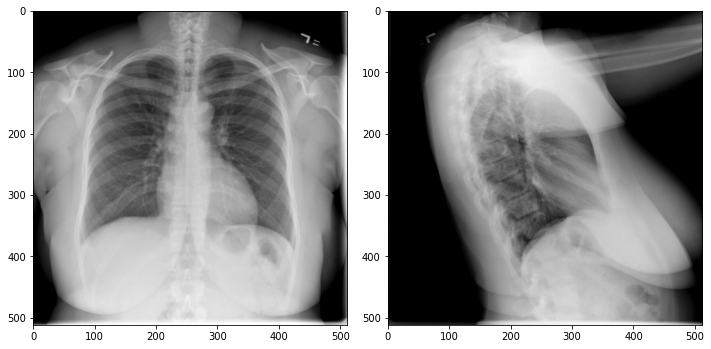

Beam Search, Beam width= 3
Actual  no acute cardiopulmonary abnormality 
Predicted: no acute cardiopulmonary disease
Individual 1-gram: 0.4777 Cumulative 1-gram: 0.4777
Individual 2-gram: 0.3583 Cumulative 2-gram: 0.4137
Individual 3-gram: 0.7165 Cumulative 3-gram: 0.4986
Individual 4-gram: 0.7165 Cumulative 4-gram: 0.5444


In [71]:
beam_predictions(X_cv.loc[3697],y_cv.loc[3697],3)

In [72]:
y_cv.index

Int64Index([3697, 1854,  478, 3331, 1705,  702, 2317, 3460, 2131, 2988,
            ...
            1539, 1520, 2701, 1051,  340, 1794, 2315, 2394,  233, 1909],
           dtype='int64', length=1220)

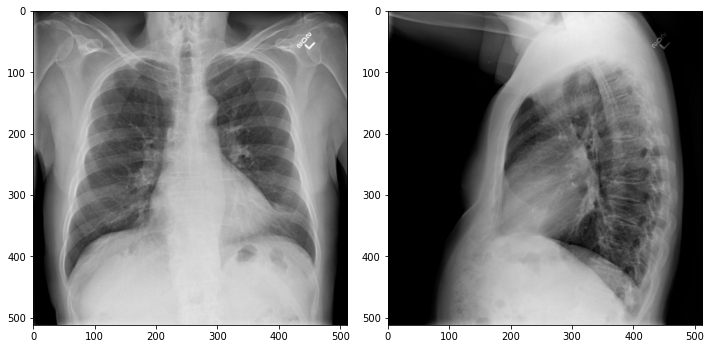

Beam Search, Beam width= 3
Actual  no acute process 
Predicted: no acute cardiopulmonary abnormality identified
Individual 1-gram: 0.2500 Cumulative 1-gram: 0.2500
Individual 2-gram: 1.0000 Cumulative 2-gram: 0.5000
Individual 3-gram: 1.0000 Cumulative 3-gram: 0.6329
Individual 4-gram: 1.0000 Cumulative 4-gram: 0.7071


In [73]:
beam_predictions(X_cv.loc[478],y_cv.loc[478],3)

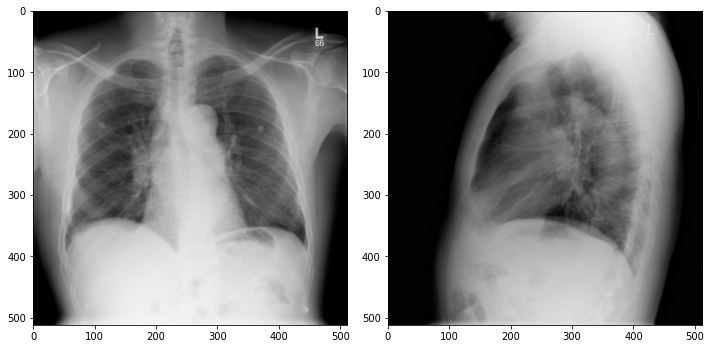

Beam Search, Beam width= 3
Actual  no acute pulmonary abnormality abnormal appearance of the mediastinum as discussed below 
Predicted: no acute cardiopulmonary abnormality identified
Individual 1-gram: 0.0677 Cumulative 1-gram: 0.0677
Individual 2-gram: 0.1353 Cumulative 2-gram: 0.0957
Individual 3-gram: 0.1353 Cumulative 3-gram: 0.1077
Individual 4-gram: 0.1353 Cumulative 4-gram: 0.1138


In [74]:
beam_predictions(X_cv.loc[1705],y_cv.loc[1705],3)

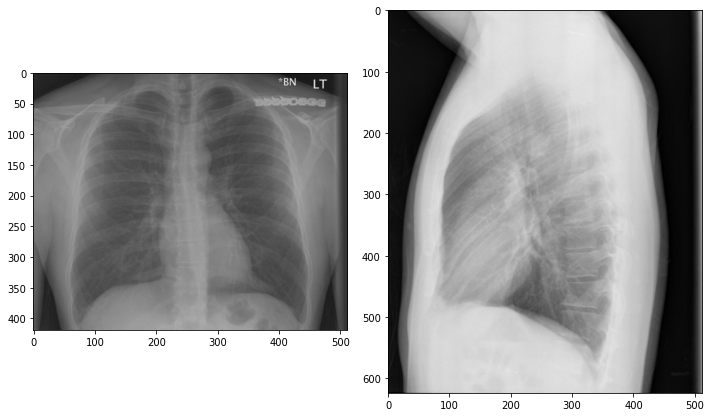

Beam Search, Beam width= 3
Actual  no acute radiographic cardiopulmonary process 
Predicted: no acute cardiopulmonary abnormality identified
Individual 1-gram: 0.3894 Cumulative 1-gram: 0.3894
Individual 2-gram: 0.7788 Cumulative 2-gram: 0.5507
Individual 3-gram: 0.7788 Cumulative 3-gram: 0.6196
Individual 4-gram: 0.7788 Cumulative 4-gram: 0.6549


In [75]:
beam_predictions(X_cv.loc[419],y_cv.loc[419],3)

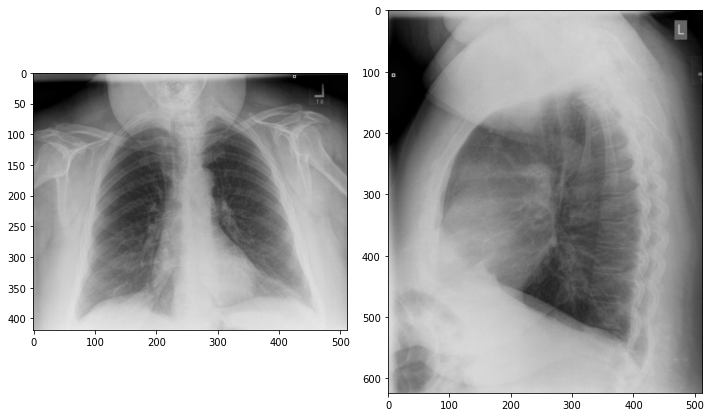

Beam Search, Beam width= 3
Actual  no acute disease 
Predicted: no acute cardiopulmonary abnormality identified
Individual 1-gram: 0.2500 Cumulative 1-gram: 0.2500
Individual 2-gram: 1.0000 Cumulative 2-gram: 0.5000
Individual 3-gram: 1.0000 Cumulative 3-gram: 0.6329
Individual 4-gram: 1.0000 Cumulative 4-gram: 0.7071


In [76]:
beam_predictions(X_cv.loc[1909],y_cv.loc[1909],3)

# BLEU SCORE :

In [77]:
bleu1 = []
bleu2 = []
bleu3 = []
bleu4 = []
for two_images, actual_text in zip(X_cv.values, y_cv.values):
  
    actual_text = actual_text.split()[1:]
    actual_text = actual_text[:len(actual_text)-1]
    actual_text = ' '.join(i for i in actual_text)
    
    _,pred_text,_ = evaluate(two_images)
    
   # print(pred_text)
    #print("\n",actual_text)
    bleu1.append(sentence_bleu([actual_text.split()], pred_text.split(), weights = (1,0,0,0)))
    bleu2.append(sentence_bleu([actual_text.split()], pred_text.split(), weights = (0.5,0.5,0,0)))
    bleu3.append(sentence_bleu([actual_text.split()], pred_text.split(), weights = (0.33,0.33,0.33,0)))
    bleu4.append(sentence_bleu([actual_text.split()], pred_text.split(), weights = (0.25,0.25,0.25,0.25)))
    

In [78]:
print('Bleu1 Score: ', sum(bleu1)/X_cv.shape[0])
print('Bleu2 Score: ', sum(bleu2)/X_cv.shape[0])
print('Bleu3 Score: ', sum(bleu3)/X_cv.shape[0])
print('Bleu4 Score: ', sum(bleu4)/X_cv.shape[0])

Bleu1 Score:  0.35512769060284316
Bleu2 Score:  0.3492752536086716
Bleu3 Score:  0.36857529398777256
Bleu4 Score:  0.39952116420213524


# Summary:


1. Extracting feature vector of each image using EfficientNetB7, which has best AUC on imagenet data.
 Feature vector is [1,2560], which has to reshaped for attention [32,80].
 We can get 32 Attention weights.

2. Using glove vector for word representation improved model performance immensely.
6. Using Attention based Encoder-Decoder model has improved loss and converged faster.
7. Model performs well on small sentences and Blue score is 0.3995